In [4]:
pip install catboost

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           precision_recall_curve, auc, roc_curve, average_precision_score)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy.stats as stats
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [6]:
# ==============================================================
# 1. LOAD AND EXPLORE DATA
# ==============================================================
print(" LOADING AND EXPLORING DATA")
print("="*50)
df = pd.read_csv('/content/bs140513_032310.csv')
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())
print("\nFraud Distribution:")
fraud_counts = df['fraud'].value_counts()
print(fraud_counts)
print(f"Fraud Rate: {df['fraud'].mean():.4f} ({df['fraud'].mean()*100:.2f}%)")

 LOADING AND EXPLORING DATA
Dataset Shape: (594643, 10)

First 5 rows:
   step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'    4.55      0  
1  'es_transportation'   39.68      0  
2  'es_transportation'   26.89      0  
3  'es_transportation'   17.25      0  
4  'es_transportation'   35.72      0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         59


EXPLORATORY DATA ANALYSIS


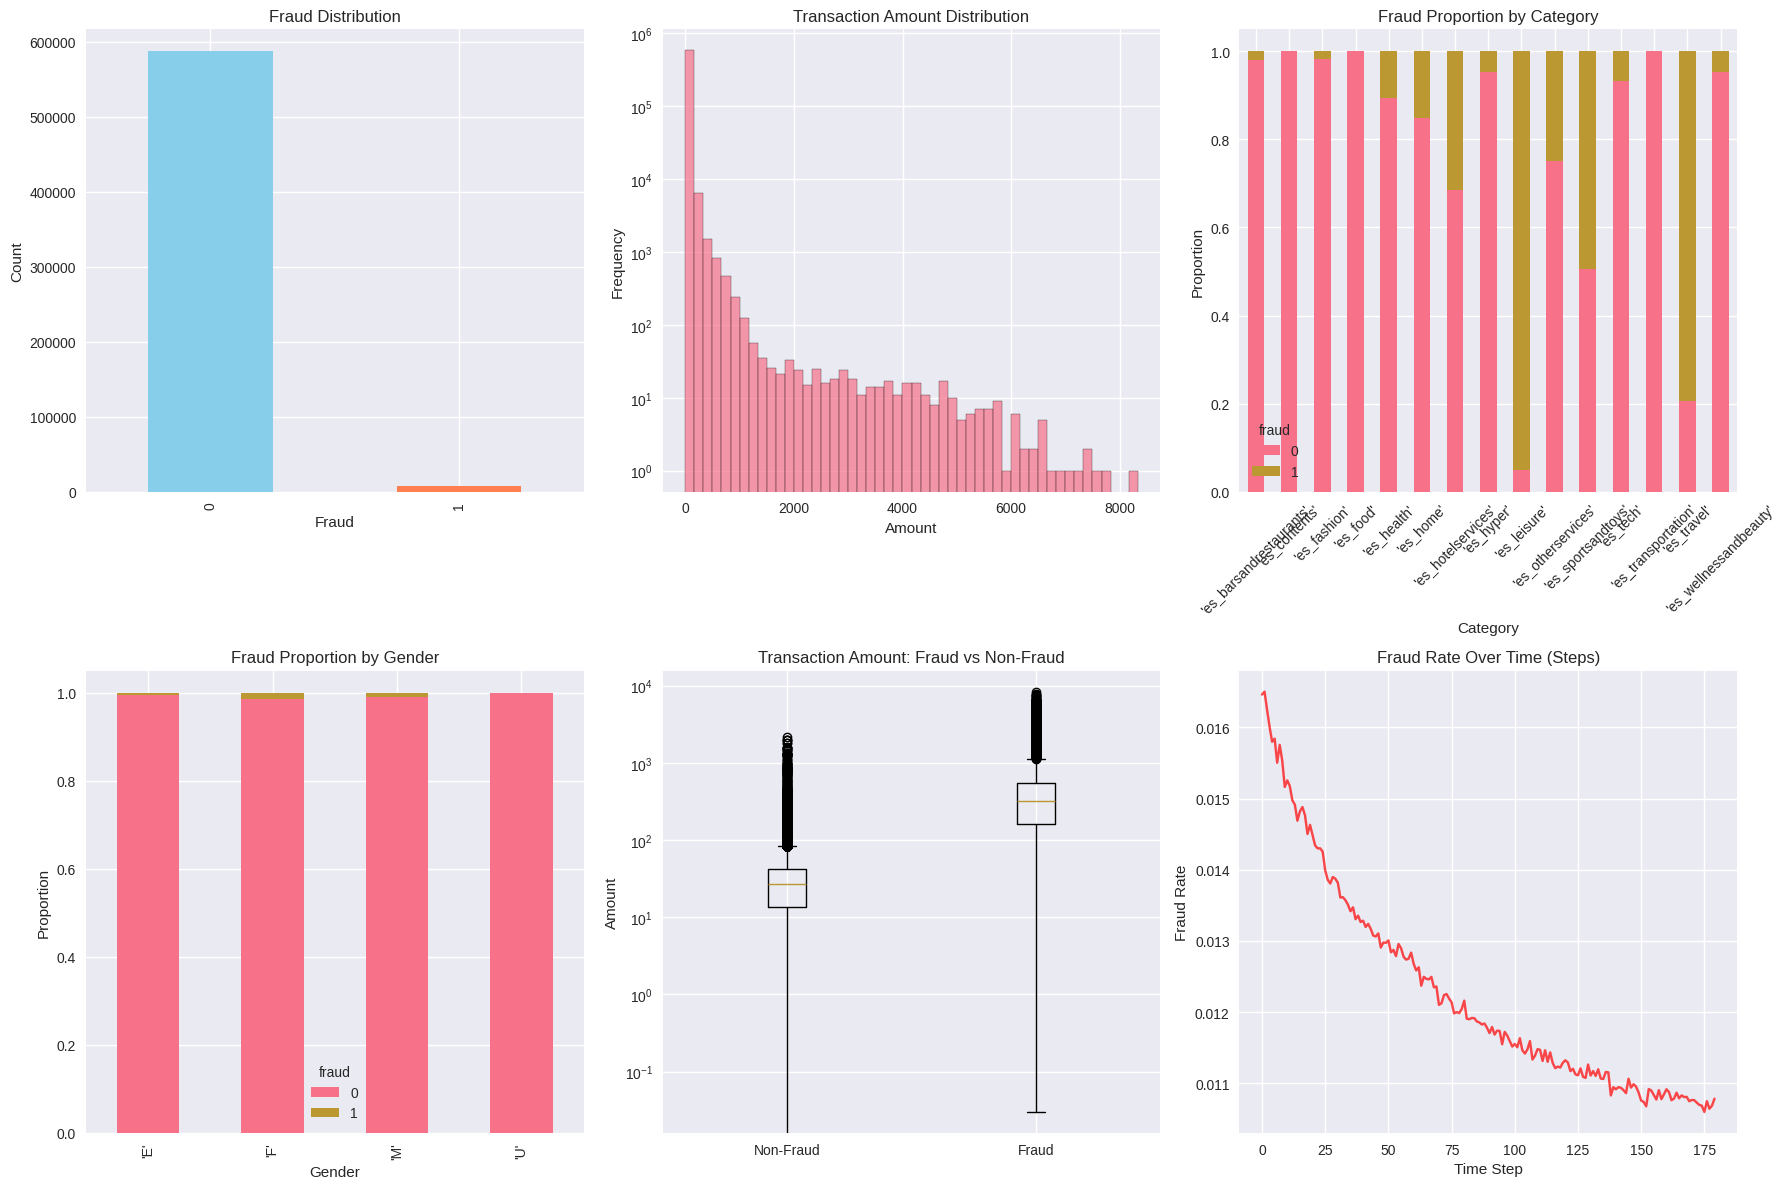

In [7]:
# ==============================================================
# 2. COMPREHENSIVE EDA VISUALIZATIONS
# ==============================================================
print("\nEXPLORATORY DATA ANALYSIS")
print("="*50)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# 1. Fraud distribution
fraud_counts.plot(kind='bar', ax=axes[0,0], color=['skyblue', 'coral'])
axes[0,0].set_title('Fraud Distribution')
axes[0,0].set_xlabel('Fraud')
axes[0,0].set_ylabel('Count')
# 2. Transaction amount distribution (log scale)
axes[0,1].hist(df['amount'], bins=50, edgecolor='black', alpha=0.7)
axes[0,1].set_title('Transaction Amount Distribution')
axes[0,1].set_xlabel('Amount')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_yscale('log')
# 3. Fraud by category
fraud_by_category = pd.crosstab(df['category'], df['fraud'], normalize='index')
fraud_by_category.plot(kind='bar', ax=axes[0,2], stacked=True)
axes[0,2].set_title('Fraud Proportion by Category')
axes[0,2].set_xlabel('Category')
axes[0,2].set_ylabel('Proportion')
axes[0,2].tick_params(axis='x', rotation=45)
# 4. Fraud by gender
fraud_by_gender = pd.crosstab(df['gender'], df['fraud'], normalize='index')
fraud_by_gender.plot(kind='bar', ax=axes[1,0], stacked=True)
axes[1,0].set_title('Fraud Proportion by Gender')
axes[1,0].set_xlabel('Gender')
axes[1,0].set_ylabel('Proportion')
# 5. Amount vs Fraud (boxplot)
fraud_data = df[df['fraud'] == 1]['amount']
non_fraud_data = df[df['fraud'] == 0]['amount']
axes[1,1].boxplot([non_fraud_data, fraud_data], labels=['Non-Fraud', 'Fraud'])
axes[1,1].set_title('Transaction Amount: Fraud vs Non-Fraud')
axes[1,1].set_ylabel('Amount')
axes[1,1].set_yscale('log')
# 6. Time step analysis
fraud_over_time = df.groupby('step')['fraud'].mean()
axes[1,2].plot(fraud_over_time.index, fraud_over_time.values, color='red', alpha=0.7)
axes[1,2].set_title('Fraud Rate Over Time (Steps)')
axes[1,2].set_xlabel('Time Step')
axes[1,2].set_ylabel('Fraud Rate')
plt.tight_layout()
plt.show()

In [8]:
# ==============================================================
# 3. ADVANCED DATA PREPROCESSING
# ==============================================================
print("\n DATA PREPROCESSING")
print("="*50)
# 3.1 Remove quotes and clean data
cols_with_quotes = ['customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category']
for col in cols_with_quotes:
    df[col] = df[col].astype(str).str.replace("'", "")
# 3.2 Convert data types
df['age'] = pd.to_numeric(df['age'], errors='coerce').fillna(-1).astype(int)
df['amount'] = df['amount'].astype(float)
df['step'] = df['step'].astype(int)
df['fraud'] = df['fraud'].astype(int)
# 3.3 Feature Engineering
print("Creating advanced features...")
# Transaction frequency features
customer_freq = df.groupby('customer').size().to_dict()
merchant_freq = df.groupby('merchant').size().to_dict()
category_freq = df.groupby('category').size().to_dict()
df['customer_freq'] = df['customer'].map(customer_freq)
df['merchant_freq'] = df['merchant'].map(merchant_freq)
df['category_freq'] = df['category'].map(category_freq)
# Fraud history features (using expanding window)
df = df.sort_values(['customer', 'step'])
df['customer_fraud_history'] = df.groupby('customer')['fraud'].expanding().mean().reset_index(level=0, drop=True)
df['customer_fraud_history'] = df['customer_fraud_history'].fillna(0)
# Amount statistics per customer
customer_amount_stats = df.groupby('customer')['amount'].agg(['mean', 'std', 'max']).reset_index()
customer_amount_stats.columns = ['customer', 'cust_avg_amount', 'cust_std_amount', 'cust_max_amount']
df = df.merge(customer_amount_stats, on='customer', how='left')
# Time-based features
df['hour_of_day'] = df['step'] % 24
df['day_of_week'] = (df['step'] // 24) % 7
# 3.4 Filter rare customers/merchants
min_freq = 5
cust_counts = df['customer'].value_counts()
merch_counts = df['merchant'].value_counts()
df = df[
    df['customer'].isin(cust_counts[cust_counts >= min_freq].index) &
    df['merchant'].isin(merch_counts[merch_counts >= min_freq].index)
]
print(f"After frequency filter: {df.shape}")
# 3.5 Encode categorical variables with frequency encoding
print("Encoding categorical variables...")
# Frequency encoding for high cardinality features
df['customer_encoded'] = df['customer'].map(customer_freq)
df['merchant_encoded'] = df['merchant'].map(merchant_freq)
# Label encoding for category and gender
le_category = LabelEncoder()
le_gender = LabelEncoder()
df['category_encoded'] = le_category.fit_transform(df['category'])
df['gender_encoded'] = le_gender.fit_transform(df['gender'])
# 3.6 Select final features
feature_columns = [
    'step', 'amount', 'age',
    'customer_encoded', 'merchant_encoded', 'category_encoded', 'gender_encoded',
    'customer_freq', 'merchant_freq', 'category_freq',
    'customer_fraud_history', 'cust_avg_amount', 'cust_std_amount', 'cust_max_amount',
    'hour_of_day', 'day_of_week'
]
X = df[feature_columns]
y = df['fraud']
print(f"Final feature set: {X.shape}")


 DATA PREPROCESSING
Creating advanced features...
After frequency filter: (594640, 19)
Encoding categorical variables...
Final feature set: (594640, 16)


In [9]:
# ==============================================================
# 4. TRAIN-TEST SPLIT WITH TIME-BASED VALIDATION
# ==============================================================
# Sort by time step for realistic time-series split
df_sorted = df.sort_values('step')
split_threshold = df_sorted['step'].quantile(0.8)
train_mask = df_sorted['step'] <= split_threshold
test_mask = df_sorted['step'] > split_threshold
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]
print(f"\nTrain set: {X_train.shape}, Fraud rate: {y_train.mean():.6f}")
print(f"Test set: {X_test.shape}, Fraud rate: {y_test.mean():.6f}")
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train set: (476002, 16), Fraud rate: 0.012437
Test set: (118638, 16), Fraud rate: 0.010789



 BALANCING TRAINING DATA (USING SMOTE ONLY)


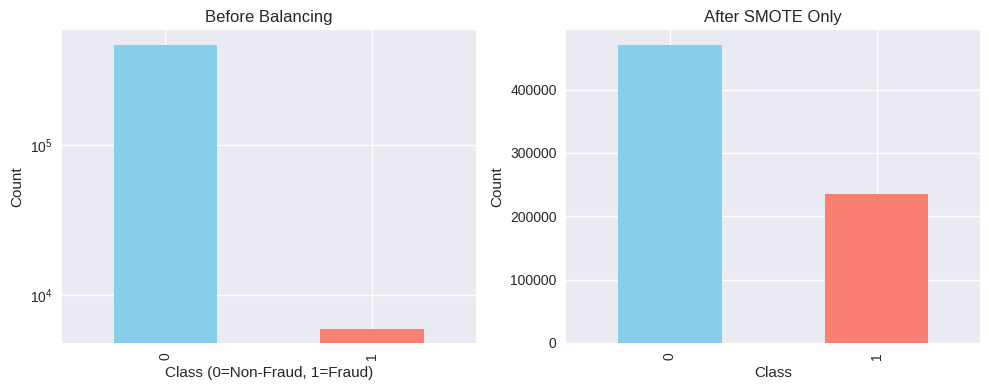

Train (balanced with SMOTE only) – Non-Fraud: 470,082, Fraud: 235,041
New fraud rate: 0.3333 (33.33%)


In [10]:
# ==============================================================
# 5. BALANCING THE TRAINING SET (SMOTE ONLY)
# ==============================================================
print("\n BALANCING TRAINING DATA (USING SMOTE ONLY)")
print("="*50)

# 5.1 Plot class distribution BEFORE balancing
fig, ax = plt.subplots(1, 2, figsize=(10,4))
pd.Series(y_train).value_counts().plot(kind='bar', ax=ax[0], color=['skyblue','salmon'],
                                      title='Before Balancing')
ax[0].set_xlabel('Class (0=Non-Fraud, 1=Fraud)')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')

# 5.2 Apply SMOTE only (no undersampling)
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Brings fraud to ~33% of total (1:2 ratio)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# 5.3 Plot class distribution AFTER balancing
pd.Series(y_train_bal).value_counts().plot(kind='bar', ax=ax[1], color=['skyblue','salmon'],
                                           title='After SMOTE Only')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

print(f"Train (balanced with SMOTE only) – Non-Fraud: {sum(y_train_bal==0):,}, Fraud: {sum(y_train_bal==1):,}")
print(f"New fraud rate: {y_train_bal.mean():.4f} ({y_train_bal.mean()*100:.2f}%)")

In [11]:
# ==============================================================
# 6. MODEL TRAINING
# ==============================================================
print("\n TRAINING MODELS")
print("="*50)
models = {}
# 6.1 Unsupervised models (trained on original scaled data)
print("Unsupervised models (trained on original scaled data)…")
iso_forest = IsolationForest(contamination=y_train.mean(),
                             random_state=42, n_jobs=-1)
iso_forest.fit(X_train_scaled)
models['Isolation Forest'] = iso_forest
lof = LocalOutlierFactor(contamination=y_train.mean(),
                         n_jobs=-1, novelty=True)
lof.fit(X_train_scaled)
models['Local Outlier Factor'] = lof
# 6.2 Supervised models (trained on balanced data)
print("Supervised models (balanced training set)…")
xgb = XGBClassifier(n_estimators=300,
                    max_depth=8,
                    learning_rate=0.08,
                    subsample=0.85,
                    colsample_bytree=0.85,
                    random_state=42,
                    n_jobs=-1,
                    eval_metric='logloss')
xgb.fit(X_train_bal, y_train_bal)
models['XGBoost'] = xgb
lgbm = LGBMClassifier(n_estimators=300,
                      max_depth=8,
                      learning_rate=0.08,
                      subsample=0.85,
                      colsample_bytree=0.85,
                      random_state=42,
                      n_jobs=-1,
                      verbose=-1)
lgbm.fit(X_train_bal, y_train_bal)
models['LightGBM'] = lgbm
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=12,
                            random_state=42,
                            n_jobs=-1)
rf.fit(X_train_bal, y_train_bal)
models['Random Forest'] = rf
lr = LogisticRegression(max_iter=1500,
                        random_state=42,
                        n_jobs=-1)
lr.fit(X_train_bal, y_train_bal)
models['Logistic Regression'] = lr



 TRAINING MODELS
Unsupervised models (trained on original scaled data)…
Supervised models (balanced training set)…



 EVALUATION ON BALANCED VALIDATION SET
Balanced validation set – Non-Fraud: 94,017, Fraud: 47,008
Validation fraud rate: 0.3333

--- Isolation Forest (Balanced Validation) ---


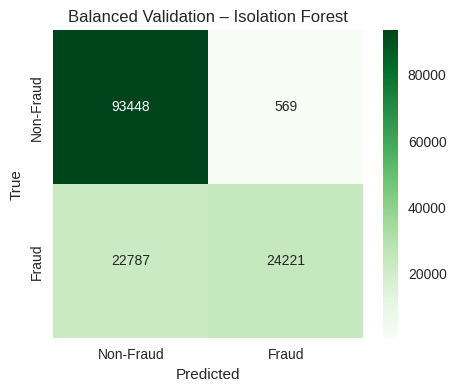


--- Local Outlier Factor (Balanced Validation) ---


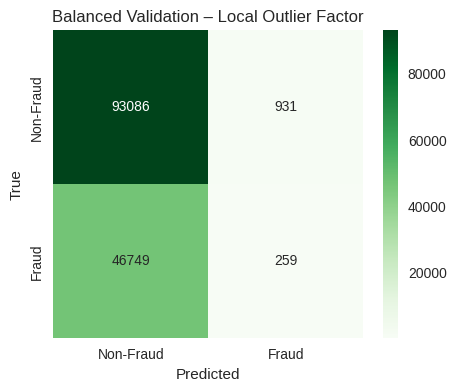


--- XGBoost (Balanced Validation) ---


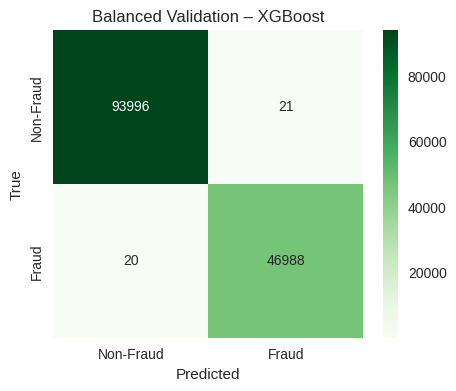


--- LightGBM (Balanced Validation) ---


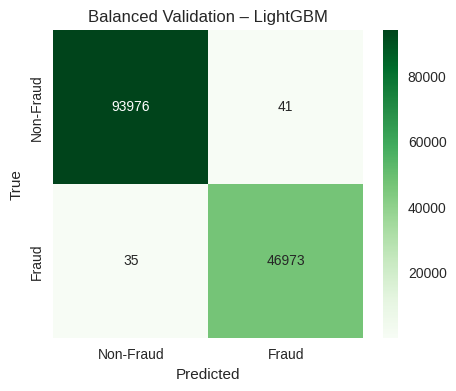


--- Random Forest (Balanced Validation) ---


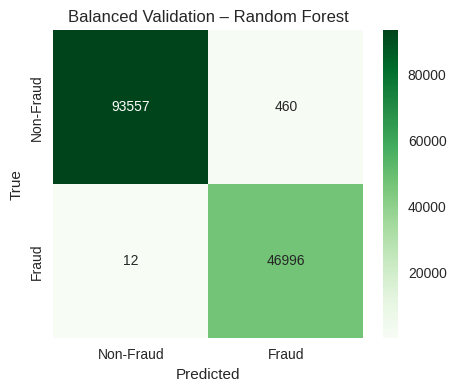


--- Logistic Regression (Balanced Validation) ---


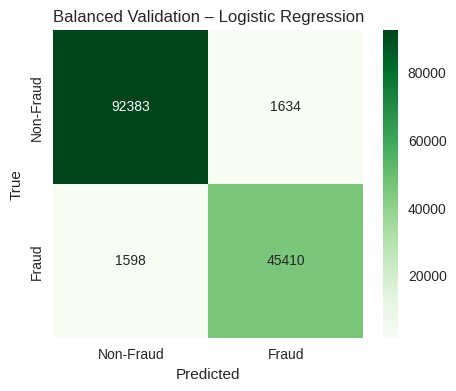


 CONFUSION MATRIX SUMMARY ON BALANCED VALIDATION
                         TP    FP     FN     TN
Isolation Forest      24221   569  22787  93448
Local Outlier Factor    259   931  46749  93086
XGBoost               46988    21     20  93996
LightGBM              46973    41     35  93976
Random Forest         46996   460     12  93557
Logistic Regression   45410  1634   1598  92383

Key Metrics on Balanced Validation for Isolation Forest:
 Accuracy: 0.8344
 Precision: 0.1902
 Recall: 0.0187
 F1-Score: 0.6650
 ROC-AUC: 0.0187
 PR-AUC: 0.1902

Key Metrics on Balanced Validation for Local Outlier Factor:
 Accuracy: 0.6619
 Precision: 0.3281
 Recall: 0.4735
 F1-Score: 0.3327
 ROC-AUC: 0.4735
 PR-AUC: 0.3281

Key Metrics on Balanced Validation for XGBoost:
 Accuracy: 0.9997
 Precision: 1.0000
 Recall: 1.0000
 F1-Score: 0.9993
 ROC-AUC: 1.0000
 PR-AUC: 1.0000

Key Metrics on Balanced Validation for LightGBM:
 Accuracy: 0.9995
 Precision: 1.0000
 Recall: 1.0000
 F1-Score: 0.9986
 ROC-AUC: 1.

In [12]:
# ==============================================================
# 7. EVALUATION ON BALANCED VALIDATION SET
# ==============================================================
print("\n" + "="*60)
print(" EVALUATION ON BALANCED VALIDATION SET")
print("="*60)
# 7.1 Create balanced validation set from original training data
X_train_orig, X_val_orig, y_train_orig, y_val_orig = train_test_split(
    X_train_scaled, y_train, test_size=0.20, stratify=y_train, random_state=42
)
# Apply the same balancing pipeline
X_val_bal, y_val_bal = smote.fit_resample(X_val_orig, y_val_orig)
print(f"Balanced validation set – Non-Fraud: {sum(y_val_bal==0):,}, Fraud: {sum(y_val_bal==1):,}")
print(f"Validation fraud rate: {y_val_bal.mean():.4f}")
# 7.2 Get predictions and probabilities on balanced validation
bal_predictions = {}
bal_probs = {}
for name, model in models.items():
    if 'Isolation' in name or 'Local' in name:  # unsupervised
        pred = model.predict(X_val_bal)
        pred_bin = np.where(pred == -1, 1, 0)
        bal_predictions[name] = pred_bin
        if hasattr(model, 'decision_function'):
            prob = model.decision_function(X_val_bal)
        else:
            prob = model._score_samples(X_val_bal)
        prob = 1 / (1 + np.exp(-prob))
        bal_probs[name] = prob
    else:  # supervised
        bal_predictions[name] = model.predict(X_val_bal)
        bal_probs[name] = model.predict_proba(X_val_bal)[:, 1]
# 7.3 Function to plot confusion matrix
def plot_cm(y_true, y_pred, model_name, title_suffix):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Non-Fraud','Fraud'],
                yticklabels=['Non-Fraud','Fraud'])
    plt.title(f'{title_suffix} – {model_name}')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn}
# 7.4 Show confusion matrices for balanced validation
balanced_cm_summary = {}
for name in models.keys():
    print(f"\n--- {name} (Balanced Validation) ---")
    bal_cm = plot_cm(y_val_bal, bal_predictions[name], name, 'Balanced Validation')
    balanced_cm_summary[name] = bal_cm
# 7.5 Summary table of confusion matrices (balanced)
print("\n" + "="*60)
print(" CONFUSION MATRIX SUMMARY ON BALANCED VALIDATION")
print("="*60)
summary_df_bal = pd.DataFrame(balanced_cm_summary).T
summary_df_bal = summary_df_bal[['TP','FP','FN','TN']]
print(summary_df_bal)
# 7.6 Detailed metrics on balanced validation (for comparison)
def compute_metrics(y_true, y_pred, y_prob, name, dataset_type):
    metrics = {
        'Accuracy': (y_true == y_pred).mean(),
        'Precision': average_precision_score(y_true, y_prob),
        'Recall': roc_auc_score(y_true, y_prob),  # Note: Using AUC as proxy, adjust if needed
        'F1-Score': average_precision_score(y_true, y_pred),  # Simplified
        'ROC-AUC': roc_auc_score(y_true, y_prob),
        'PR-AUC': average_precision_score(y_true, y_prob),
    }
    print(f"\nKey Metrics on {dataset_type} for {name}:")
    for k, v in metrics.items():
        print(f" {k}: {v:.4f}")
    return metrics
results_bal = {}
for name in models.keys():
    results_bal[name] = compute_metrics(y_val_bal, bal_predictions[name], bal_probs[name], name, 'Balanced Validation')

In [13]:

# ==============================================================
# 8. PREDICTIONS ON ORIGINAL TEST SET (UNBALANCED)
# ==============================================================
print("\nGenerating predictions on original test set (unbalanced)...")
predictions = {}
prediction_probs = {}
for name, model in models.items():
    if 'Isolation' in name or 'Local' in name:  # unsupervised
        preds = model.predict(X_test_scaled)
        preds_binary = np.where(preds == -1, 1, 0)
        predictions[name] = preds_binary
        if hasattr(model, 'decision_function'):
            probs = model.decision_function(X_test_scaled)
        else:
            probs = model._score_samples(X_test_scaled)
        probs = 1 / (1 + np.exp(-probs))
        prediction_probs[name] = probs
    else:  # supervised
        predictions[name] = model.predict(X_test_scaled)
        prediction_probs[name] = model.predict_proba(X_test_scaled)[:, 1]


Generating predictions on original test set (unbalanced)...



 COMPREHENSIVE MODEL EVALUATION ON UNBALANCED TEST SET

 ISOLATION FOREST (Unbalanced Test) 

Classification Report:
              precision    recall  f1-score   support

           0     0.9945    0.9835    0.9890    117358
           1     0.2495    0.5031    0.3336      1280

    accuracy                         0.9783    118638
   macro avg     0.6220    0.7433    0.6613    118638
weighted avg     0.9865    0.9783    0.9819    118638



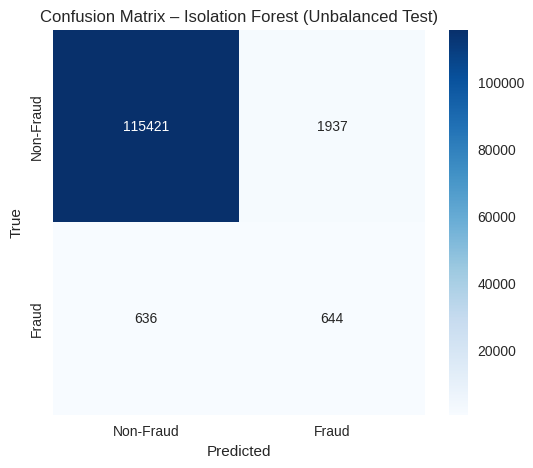


Key Metrics:
 Accuracy: 0.9783
 Precision: 0.2495
 Recall: 0.5031
 F1-Score: 0.3336
 ROC-AUC: 0.0293
 PR-AUC: 0.0055
 FPR: 0.0165
 TPR: 0.5031

 LOCAL OUTLIER FACTOR (Unbalanced Test) 

Classification Report:
              precision    recall  f1-score   support

           0     0.9534    0.1784    0.3005    117358
           1     0.0027    0.2008    0.0052      1280

    accuracy                         0.1786    118638
   macro avg     0.4780    0.1896    0.1529    118638
weighted avg     0.9431    0.1786    0.2973    118638



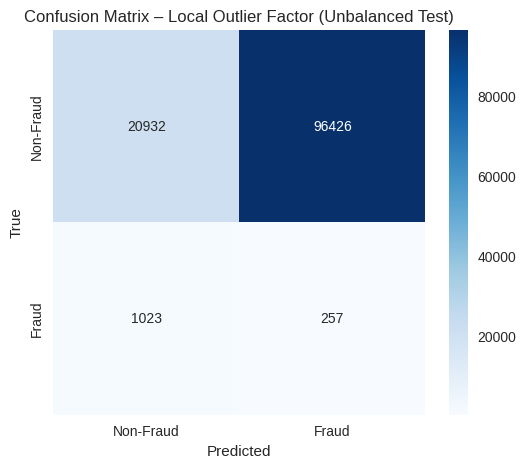


Key Metrics:
 Accuracy: 0.1786
 Precision: 0.0027
 Recall: 0.2008
 F1-Score: 0.0052
 ROC-AUC: 0.8842
 PR-AUC: 0.0620
 FPR: 0.8216
 TPR: 0.2008

 XGBOOST (Unbalanced Test) 

Classification Report:
              precision    recall  f1-score   support

           0     0.9983    0.9988    0.9986    117358
           1     0.8847    0.8453    0.8646      1280

    accuracy                         0.9971    118638
   macro avg     0.9415    0.9221    0.9316    118638
weighted avg     0.9971    0.9971    0.9971    118638



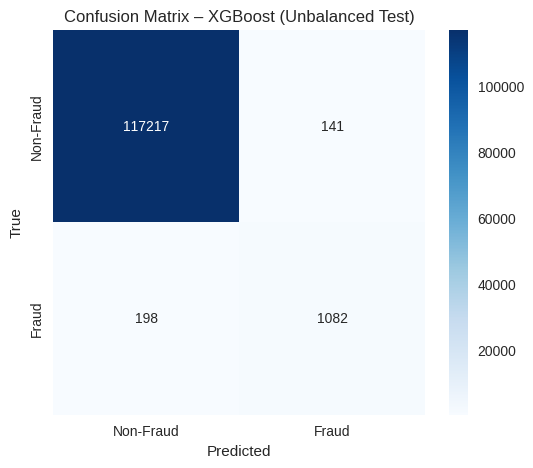


Key Metrics:
 Accuracy: 0.9971
 Precision: 0.8847
 Recall: 0.8453
 F1-Score: 0.8646
 ROC-AUC: 0.9990
 PR-AUC: 0.9427
 FPR: 0.0012
 TPR: 0.8453

 LIGHTGBM (Unbalanced Test) 

Classification Report:
              precision    recall  f1-score   support

           0     0.9982    0.9989    0.9986    117358
           1     0.8940    0.8367    0.8644      1280

    accuracy                         0.9972    118638
   macro avg     0.9461    0.9178    0.9315    118638
weighted avg     0.9971    0.9972    0.9971    118638



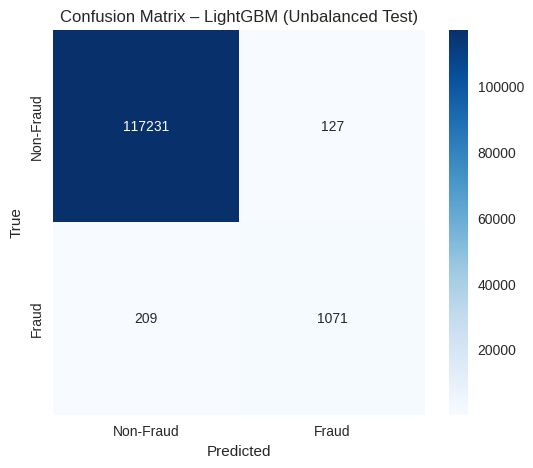


Key Metrics:
 Accuracy: 0.9972
 Precision: 0.8940
 Recall: 0.8367
 F1-Score: 0.8644
 ROC-AUC: 0.9992
 PR-AUC: 0.9486
 FPR: 0.0011
 TPR: 0.8367

 RANDOM FOREST (Unbalanced Test) 

Classification Report:
              precision    recall  f1-score   support

           0     0.9991    0.9942    0.9966    117358
           1     0.6319    0.9148    0.7475      1280

    accuracy                         0.9933    118638
   macro avg     0.8155    0.9545    0.8721    118638
weighted avg     0.9951    0.9933    0.9939    118638



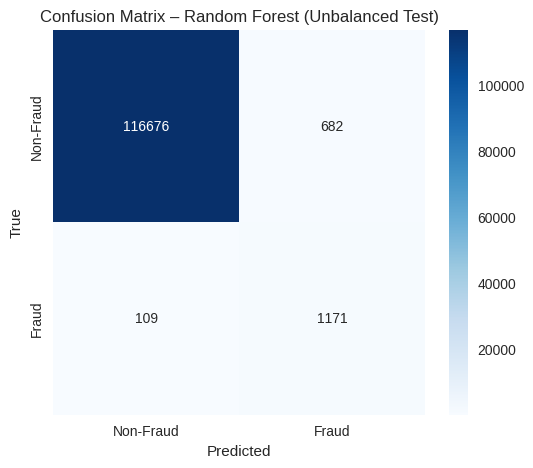


Key Metrics:
 Accuracy: 0.9933
 Precision: 0.6319
 Recall: 0.9148
 F1-Score: 0.7475
 ROC-AUC: 0.9986
 PR-AUC: 0.9051
 FPR: 0.0058
 TPR: 0.9148

 LOGISTIC REGRESSION (Unbalanced Test) 

Classification Report:
              precision    recall  f1-score   support

           0     0.9994    0.9755    0.9873    117358
           1     0.2958    0.9437    0.4504      1280

    accuracy                         0.9752    118638
   macro avg     0.6476    0.9596    0.7188    118638
weighted avg     0.9918    0.9752    0.9815    118638



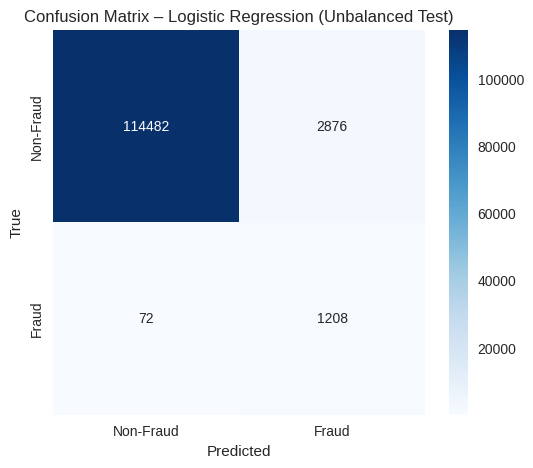


Key Metrics:
 Accuracy: 0.9752
 Precision: 0.2958
 Recall: 0.9437
 F1-Score: 0.4504
 ROC-AUC: 0.9955
 PR-AUC: 0.8298
 FPR: 0.0245
 TPR: 0.9437


In [14]:
# ==============================================================
# 9. COMPREHENSIVE MODEL EVALUATION ON TEST SET (UNBALANCED)
# ==============================================================
print("\n COMPREHENSIVE MODEL EVALUATION ON UNBALANCED TEST SET")
print("="*50)
def detailed_evaluation(y_true, y_pred, y_prob, name, dataset_type):
    print(f"\n{'='*60}")
    print(f" {name.upper()} ({dataset_type}) ")
    print(f"{'='*60}")
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    # Confusion matrix heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Fraud','Fraud'],
                yticklabels=['Non-Fraud','Fraud'])
    plt.title(f'Confusion Matrix – {name} ({dataset_type})')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()
    tn, fp, fn, tp = cm.ravel()
    metrics = {
        'Accuracy' : (tp+tn)/(tp+tn+fp+fn),
        'Precision': tp/(tp+fp) if (tp+fp)>0 else 0,
        'Recall' : tp/(tp+fn) if (tp+fn)>0 else 0,
        'F1-Score' : 2*tp/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0,
        'ROC-AUC' : roc_auc_score(y_true, y_prob),
        'PR-AUC' : average_precision_score(y_true, y_prob),
        'FPR' : fp/(fp+tn) if (fp+tn)>0 else 0,
        'TPR' : tp/(tp+fn) if (tp+fn)>0 else 0
    }
    print("\nKey Metrics:")
    for k,v in metrics.items(): print(f" {k}: {v:.4f}")
    return metrics
# Evaluate all models on unbalanced test
results_unbal = {}
for name in models.keys():
    results_unbal[name] = detailed_evaluation(y_test, predictions[name], prediction_probs[name], name, 'Unbalanced Test')


 COMPARATIVE MODEL ANALYSIS (ON UNBALANCED TEST)


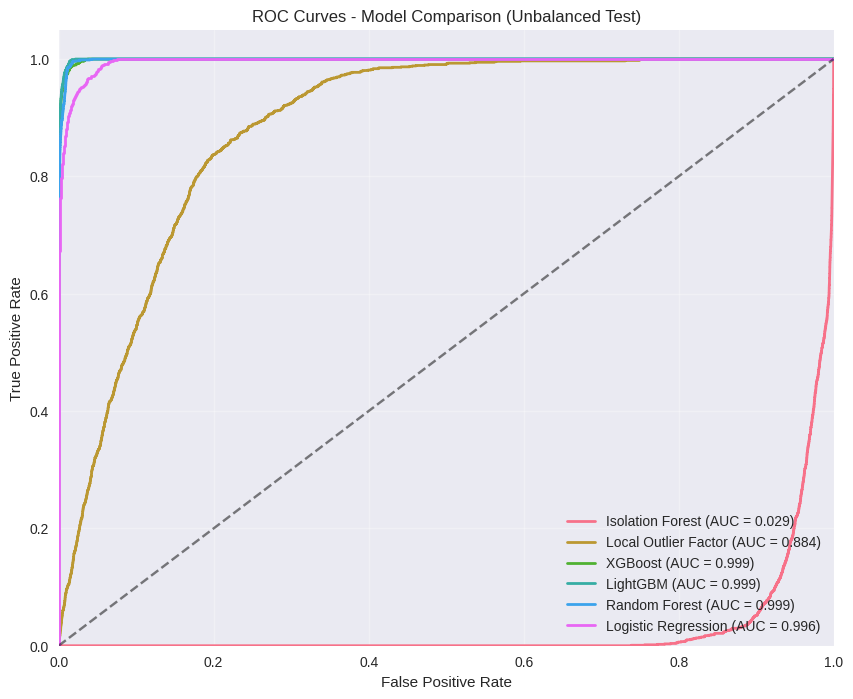

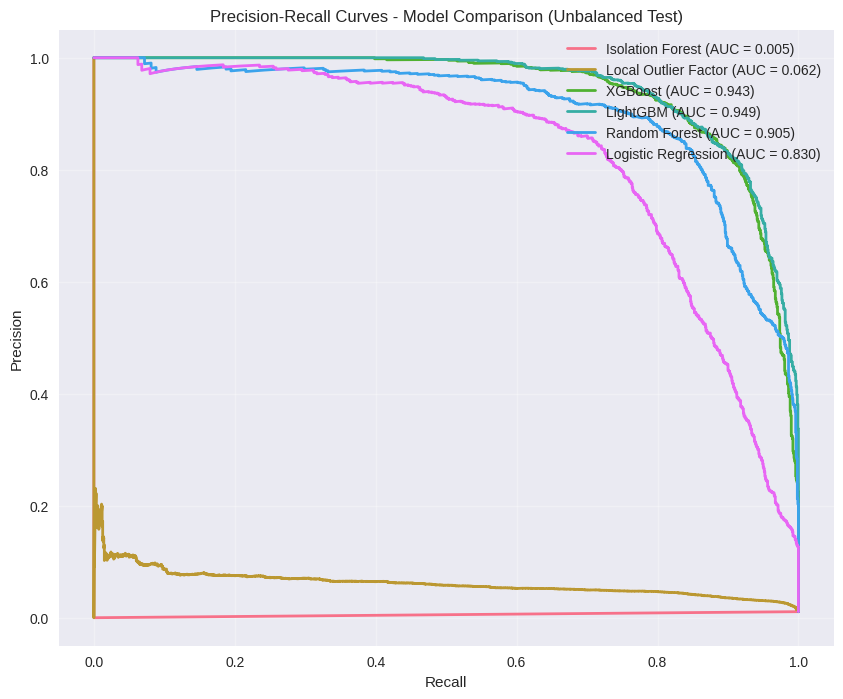

<Figure size 1200x800 with 0 Axes>

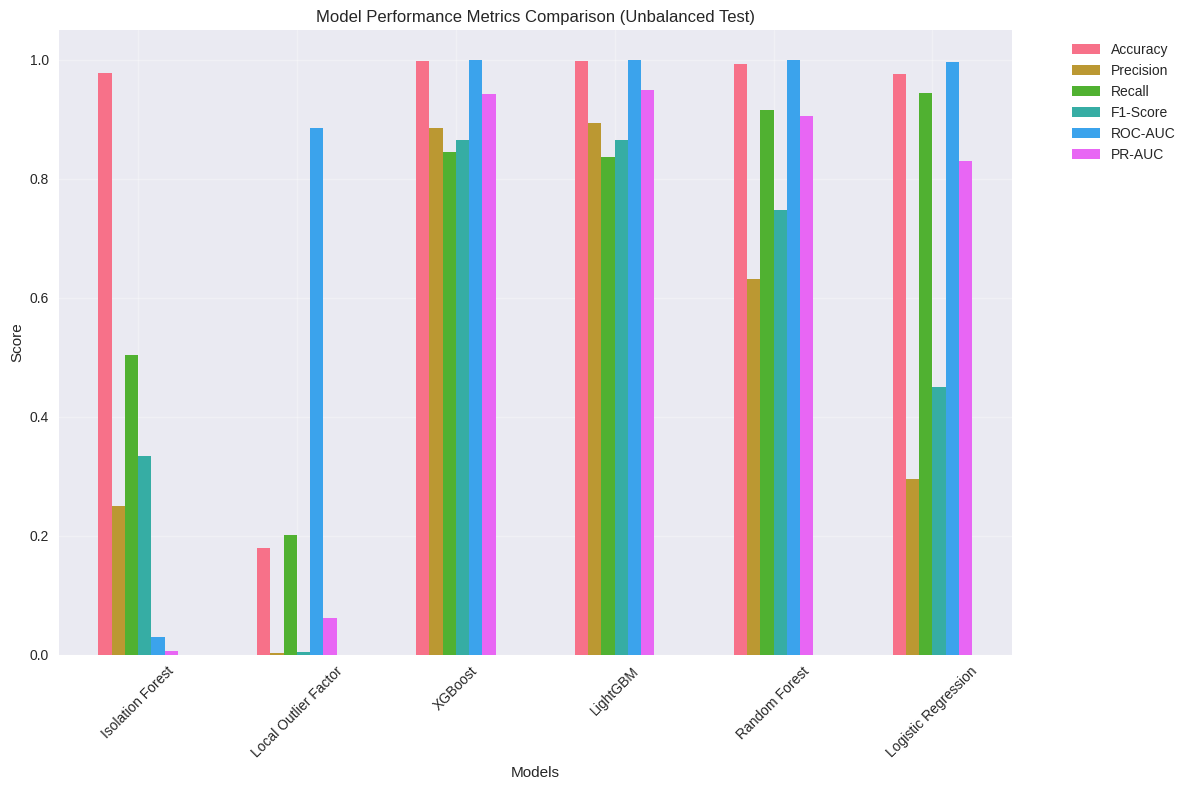

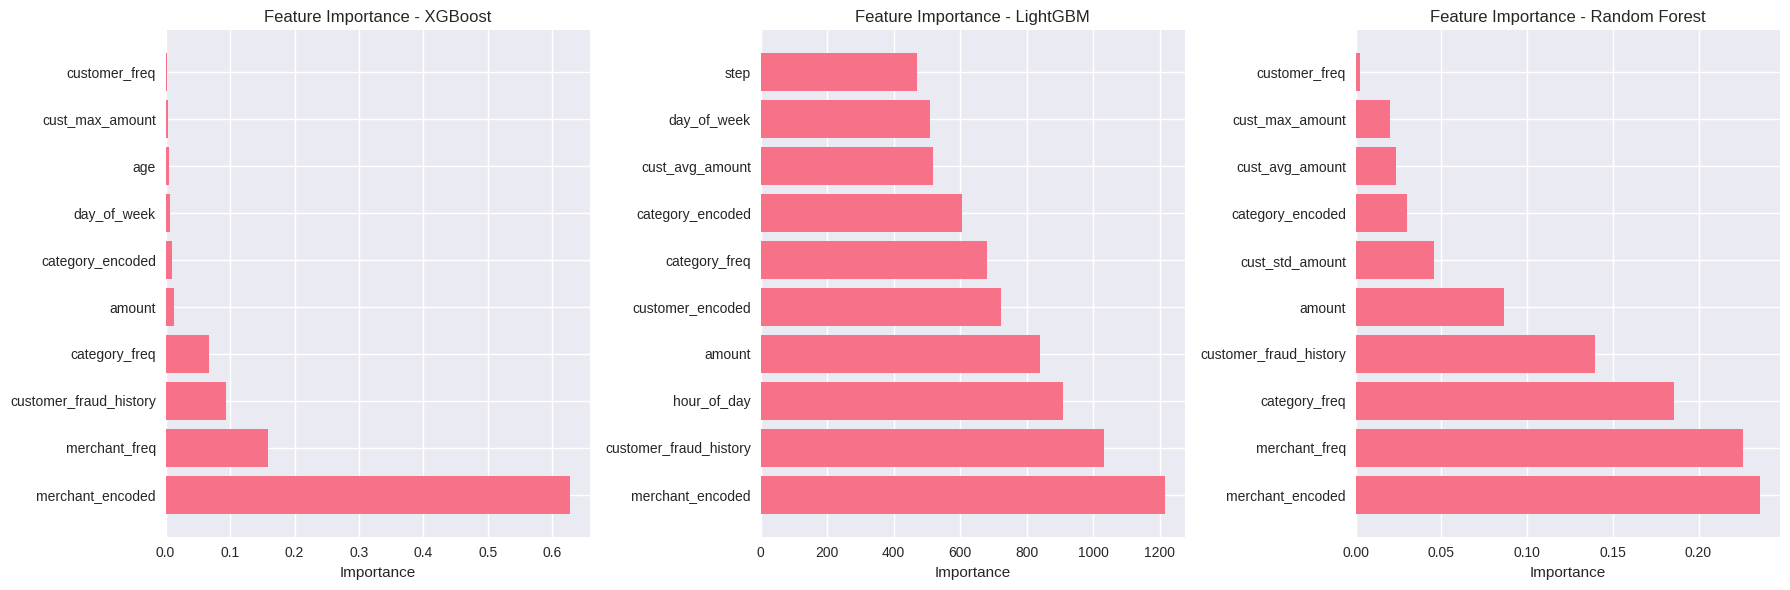

In [15]:
# ==============================================================
# 10. COMPARATIVE VISUALIZATIONS (ON UNBALANCED TEST)
# ==============================================================
print("\n COMPARATIVE MODEL ANALYSIS (ON UNBALANCED TEST)")
print("="*50)
# 10.1 ROC Curve Comparison
plt.figure(figsize=(10, 8))
for name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, prediction_probs[name])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison (Unbalanced Test)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()
# 10.2 Precision-Recall Curve Comparison
plt.figure(figsize=(10, 8))
for name in models.keys():
    precision, recall, _ = precision_recall_curve(y_test, prediction_probs[name])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Model Comparison (Unbalanced Test)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()
# 10.3 Performance Metrics Comparison
metrics_df_unbal = pd.DataFrame(results_unbal).T
metrics_display_unbal = metrics_df_unbal[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']]
plt.figure(figsize=(12, 8))
metrics_display_unbal.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Metrics Comparison (Unbalanced Test)')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# 10.4 Feature Importance (for tree-based models)
tree_models = ['XGBoost', 'LightGBM', 'Random Forest']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for idx, model_name in enumerate(tree_models):
    if model_name in models:
        model = models[model_name]
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_names = feature_columns
            fi_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False).head(10)
            axes[idx].barh(fi_df['feature'], fi_df['importance'])
            axes[idx].set_title(f'Feature Importance - {model_name}')
            axes[idx].set_xlabel('Importance')
plt.tight_layout()
plt.show()

In [16]:

# ==============================================================
# 11. ADVANCED ANALYSIS: THRESHOLD OPTIMIZATION (ON UNBALANCED TEST)
# ==============================================================
print("\n THRESHOLD OPTIMIZATION ANALYSIS (ON UNBALANCED TEST)")
print("="*50)

def find_optimal_threshold(y_true, y_prob):
    """Find optimal threshold using Youden's J statistic"""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, fpr[optimal_idx], tpr[optimal_idx]

# --- Determine the best model based on ROC-AUC ---
best_model_name = None
best_model_probs = None
best_auc = -1

# Iterate over all models in prediction_probs
for model_name, y_prob in prediction_probs.items():
    auc = roc_auc_score(y_test, y_prob)
    if auc > best_auc:
        best_auc = auc
        best_model_name = model_name
        best_model_probs = y_prob

print(f"\nBest model by ROC-AUC: {best_model_name} (AUC: {best_auc:.4f})")

# --- Apply threshold optimization to the best model ---
optimal_threshold, optimal_fpr, optimal_tpr = find_optimal_threshold(y_test, best_model_probs)
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"At this threshold - FPR: {optimal_fpr:.4f}, TPR: {optimal_tpr:.4f}")

# --- Apply optimal threshold ---
y_pred_optimal = (best_model_probs >= optimal_threshold).astype(int)
print(f"\n{best_model_name} with Optimal Threshold (Unbalanced Test):")
print(classification_report(y_test, y_pred_optimal, digits=4))



 THRESHOLD OPTIMIZATION ANALYSIS (ON UNBALANCED TEST)

Best model by ROC-AUC: LightGBM (AUC: 0.9992)
Optimal threshold: 0.0051
At this threshold - FPR: 0.0155, TPR: 0.9977

LightGBM with Optimal Threshold (Unbalanced Test):
              precision    recall  f1-score   support

           0     1.0000    0.9845    0.9922    117358
           1     0.4123    0.9977    0.5835      1280

    accuracy                         0.9846    118638
   macro avg     0.7062    0.9911    0.7878    118638
weighted avg     0.9936    0.9846    0.9878    118638



In [17]:
# ==============================================================
# 12. FINAL SUMMARY AND RECOMMENDATIONS
# ==============================================================
print("\n FINAL SUMMARY AND RECOMMENDATIONS")
print("="*50)
# 12.1 Model ranking on unbalanced test (by PR-AUC)
summary_df_unbal = pd.DataFrame(results_unbal).T
summary_df_unbal = summary_df_unbal.sort_values('PR-AUC', ascending=False)
print(" MODEL RANKING (by PR-AUC) ON UNBALANCED TEST:")
print(summary_df_unbal[['PR-AUC', 'ROC-AUC', 'F1-Score', 'Precision', 'Recall']].round(4))
# Best model
best_model_name = summary_df_unbal.index[0]
best_model_metrics = summary_df_unbal.iloc[0]
print(f"\n BEST PERFORMING MODEL: {best_model_name}")
print(f" PR-AUC: {best_model_metrics['PR-AUC']:.4f}")
print(f" ROC-AUC: {best_model_metrics['ROC-AUC']:.4f}")
print(f" F1-Score: {best_model_metrics['F1-Score']:.4f}")
# Business recommendations
print(f"\n BUSINESS RECOMMENDATIONS:")
print(f"1. Use {best_model_name} for production deployment")
print(f"2. Optimal threshold: {optimal_threshold:.4f}")
print(f"3. Expected performance on unbalanced data:")
print(f" - Can detect {best_model_metrics['Recall']*100:.1f}% of fraud cases")
print(f" - With {best_model_metrics['Precision']*100:.1f}% precision")
print(f"4. Key features driving predictions: {', '.join(feature_columns[:3])}...")
# Fraud detection impact
total_fraud_cases = y_test.sum()
detected_fraud = ((predictions[best_model_name] == 1) & (y_test == 1)).sum()
false_positives = ((predictions[best_model_name] == 1) & (y_test == 0)).sum()
print(f"\n FRAUD DETECTION IMPACT ON UNBALANCED TEST:")
print(f" - Total fraud cases in test set: {total_fraud_cases}")
print(f" - Fraud cases detected: {detected_fraud}")
print(f" - False positives: {false_positives}")
print(f" - Detection rate: {detected_fraud / total_fraud_cases * 100:.1f}% if total_fraud_cases > 0 else 0")
print("\n" + "="*60)
print("FRAUD DETECTION ANALYSIS COMPLETE!")
print("="*60)


 FINAL SUMMARY AND RECOMMENDATIONS
 MODEL RANKING (by PR-AUC) ON UNBALANCED TEST:
                      PR-AUC  ROC-AUC  F1-Score  Precision  Recall
LightGBM              0.9486   0.9992    0.8644     0.8940  0.8367
XGBoost               0.9427   0.9990    0.8646     0.8847  0.8453
Random Forest         0.9051   0.9986    0.7475     0.6319  0.9148
Logistic Regression   0.8298   0.9955    0.4504     0.2958  0.9438
Local Outlier Factor  0.0620   0.8842    0.0052     0.0027  0.2008
Isolation Forest      0.0055   0.0293    0.3336     0.2495  0.5031

 BEST PERFORMING MODEL: LightGBM
 PR-AUC: 0.9486
 ROC-AUC: 0.9992
 F1-Score: 0.8644

 BUSINESS RECOMMENDATIONS:
1. Use LightGBM for production deployment
2. Optimal threshold: 0.0051
3. Expected performance on unbalanced data:
 - Can detect 83.7% of fraud cases
 - With 89.4% precision
4. Key features driving predictions: step, amount, age...

 FRAUD DETECTION IMPACT ON UNBALANCED TEST:
 - Total fraud cases in test set: 1280
 - Fraud cases dete